# Data preproccessing and classifier implementation 

In this notebook, data will be preprocessed and output as csv files to be used in the notebooks afterwards.
A classifier is then fitted from data split into test and training sets.

For the processes to run, 2 new folders need to be generated "data" and "data_removed" nested in "data".
This allows all the data to be preprocessed in one cell and be called from the other cells.

In [37]:
# import packages

#FIXME: array[1] vs correct_values
#FIXME: split_21 justify/change
#FIXME: remove from remove_list

%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.animation
import matplotlib.widgets
#import seaborn as sns

#from tkinter import * 
#import tkinter.messagebox 

#from sklearn.linear_model import Ridge, Lasso, ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
#from sklearn import svm
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator


## Preproccessor class

A class is made to preprocess data so these lines do not need to be call multiple times.

In [38]:
# class to preprocess data

class Preprocessor:
    
    # initalise self with data needed to be preproccessed
    def __init__ (self, data):
        self.data = data

    def encode(self, kind: str, c_name:str ):
        """encoder(kind:str, c_name)
           kind  is either onehot or label
           c_name is the name of the column that will be encoded
           """
        # update self.data with the appropriate encoder
        assert kind in ['onehot', 'label']
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scale(self, kind: str, c_name: str):
        """scale(kind:str, c_name)
           kind  is either minmax or std
           c_name is the name of the column that will be scaled"""
            
        # overwrites columns in self.data with 
        # scaled versions based on kind parameter
        
        # make sure kind is either minmax or std
        assert kind in ['minmax', 'std']

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        elif kind == 'std':
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
        else:
            print('Invalid scaler, check parameters before proceeding with ML')
            
        return self.data

    # function to remove entire column of data
    def remove (self, c_name):
        del self.data[c_name]
        return self.data
     
    # function to replace unknown data with mean, median or dropping it
    def replace (self, c_name, kind):
        assert kind in ['mean', 'median','drop']
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

## Plotter class

Plotter class was used to make scatter and line graphs, this was done to make the class as generic as possible to allow different types of data to be plotted. The line graphs were not used give as the data output was boolean, but kept in the code.

This also plots 3D graphs and radiobuttons.

In [39]:
# preplotter class to help with inital data visualisation

class preplotter:
    
    def __init__ (self, data):
        self.data = data
        
    # Function to plot linear 2D or 3D graph takes in column names and output graphs
        
    # func to plots scatter graphs 
    # for these functions column names are input, hence by setting the z name to 0 and checking it is not a string
    # we can seperate 3D plots from 2D plots
    
    # for all the functions below, they follow a similar manner
    # get fig ax objects
    # label axis
    # plot graph 
    
    def scatter(self, x_name, y_name, z_name = 0 ):
        
        # check if data has 3rd dimension
        if z_name == 0:
            
            # gen fig and ax for 2D
            fig, ax = plt.subplots()
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], alpha=0.5)
        
        # generate and for above but in 3D graph
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], self.data[z_name])    
    
    # func to plot line graphs same as above
    
    def line(self, x_name, y_name, z_name = 0):
        if z_name == 0:
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.plot(self.data[x_name], self.data[y_name])
            
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.plot(self.data[x_name], self.data[y_name], self.data[z_name])
            
    # plot multiple line plots with radio buttons
    
    def multiline (self, x_list , y_list, z_list = 0):
        
        #hard set colours to be used, don't expect more than 8 values to be plotted at once
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        # check if input has 3 dimension
        if z_list == 0:

            # gen fig, ax adjusted for radio buttons
            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            # generate empty dictionary
            lines = {}
            
            # generate line dictionary using x_list as keys
            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line[0].set_alpha(0.5)
                    else:
                        line[0].set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        # if in 3D do simple colour plot
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.plot( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()


    # plot multiple scatter plots do the same as above
    
    def multiscatter (self, x_list , y_list, z_list = 0):

        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line.set_alpha(0.5)
                    else:
                        line.set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.scatter( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()

                
    # this function plots a boolean data type's coordination with strokes
    def histogram (self, x_list):

        # initalise figure and bins
        fig, ax = plt.subplots()
        bins = [0 ,1]
        
        # filter data out based on if boolean is 1 or 0
        
        inter = self.data[self.data[x_list] == 1]
        # check amount of strokes for bool of 1
        strokes = len(inter[inter['stroke'] == 1])
        sstrokes = len(inter)
        # find % strokes
        pstrokes = (strokes/sstrokes)*100
        print(f'the percentage of strokes with 1 is {pstrokes}%.')
        
        # repear with bool of 0
        inter2 = self.data[self.data[x_list] == 0]
        nstrokes = len(inter2[inter2['stroke'] == 1])
        snstrokes = len(inter2)
        pnstrokes = (nstrokes/snstrokes)*100
        print(f'the percentage of strokes with 0 is {pnstrokes}%.')
        
        # plot these 2 percentage chances against each other and print difference
        score = [pnstrokes, pstrokes]
        ax.bar(bins,score)
        plt.title(f'{x_list} correlation to stroke')
        dv = pstrokes - pnstrokes
    
        print(f'the percentage difference is {dv}%.')
        
        return dv


## Stage 1

Here we do the 1st stage of data preproccessing using basic common sense, such as "id" being an arbitary hospital allocation.

In [40]:
# run 1st stage data preprocessing by logic

data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
# initialise preporcessor class
preprocessor = Preprocessor(data.copy())

# known id is irrelavent to stroke chance
preprocessor.remove('id')

# there is enough data to justify dropping NaN values in bmi
preprocessor.replace('bmi','drop')

# there are only 2 people with other as a gender, as insensitive as this is, they can be dropped
preprocessor.encode('onehot','gender')
preprocessor.remove("Other")

# there are only 2 marriage options, no live in partners or polygamy smh
preprocessor.encode('label','ever_married')

# more than 2 work tpyes - > onehot
preprocessor.encode('onehot','work_type')

# there are only 2 residencital types and one is obviously better than the other
preprocessor.encode('label','Residence_type')

# label encoding for smoking a hierarchy makes sense in terms of stroke risk
preprocessor.encode('label','smoking_status')

# all other data is between 1 and 0 as such to keep all data compareable, we should use minmax scaling as it also keeps
# values within 1 and 0
help(preprocessor.encode)
help(preprocessor.scale)
preprocessor.scale('minmax','age')
preprocessor.scale('minmax','avg_glucose_level')
preprocessor.scale('minmax','bmi')

#output data to another csv file
#preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv',index=False)

Help on method encode in module __main__:

encode(kind: str, c_name: str) method of __main__.Preprocessor instance
    encoder(kind:str, c_name)
    kind  is either onehot or label
    c_name is the name of the column that will be encoded

Help on method scale in module __main__:

scale(kind: str, c_name: str) method of __main__.Preprocessor instance
    scale(kind:str, c_name)
    kind  is either minmax or std
    c_name is the name of the column that will be scaled



age  hypertension  heart_disease  ever_married  Residence_type  \
0     0.816895             0              1             1               1   
1     0.975586             0              1             1               0   
2     0.597168             0              0             1               1   
3     0.963379             1              0             1               0   
4     0.987793             0              0             1               1   
...        ...           ...            ...           ...             ...   
4904  0.157715             0              0             0               0   
4905  0.987793             0              0             1               1   
4906  0.426270             0              0             1               0   
4907  0.621582             0              0             1               0   
4908  0.536133             0              0             1               1   

      avg_glucose_level       bmi  smoking_status  stroke  Male  Female  \
0              0.801265  0.301260               2       1     1       0   
1              0.234512  0.254296               1       1     1       0   
2              0.536008  0.276060               0       1     0       1   
3              0.549349  0.156930               1       1     0       1   
4              0.605161  0.214204               2       1     1       0   
...                 ...       ...             ...     ...   ...     ...   
4904           0.221402  0.095074               3       0     0       1   
4905           0.323516  0.340206               1       0     0       1   
4906           0.128658  0.232532               1       0     0       1   
4907           0.513203  0.175258               2       0     1       0   
4908           0.139230  0.182131               3       0     0       1   

      Private  Self-employed  Never_worked  Govt_job  children  
0           1              0             0         0         0  
1           1              0             0         0         0  
2           1              0             0         0         0  
3           0              1             0         0         0  
4           1              0             0         0         0  
...       ...            ...           ...       ...       ...  
4904        0              0             0         0         1  
4905        0              1             0         0         0  
4906        0              1             0         0         0  
4907        1              0             0         0         0  
4908        0              0             0         1         0  

[4909 rows x 16 columns]

## Stage 2

Here we remove boolean data based on the difference in the stroke chance if the population where bool = 1, and bool = 0. If there is a corrolation, there will be a difference in the stroke chance. Here we set an arbitary cutoff at 1.1%.

<IPython.core.display.Javascript object>


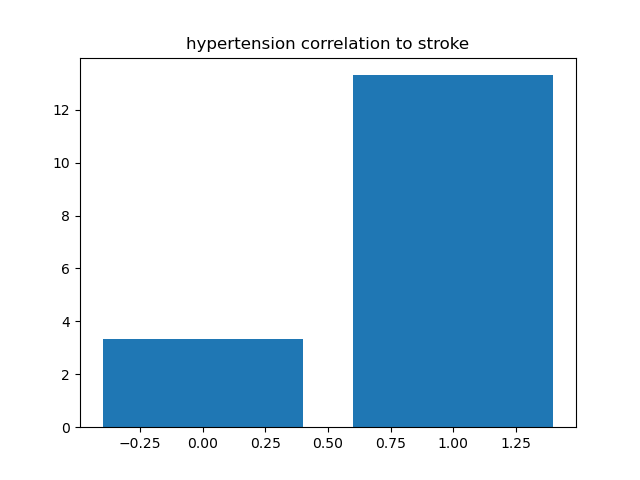

the percentage of strokes with 1 is 13.303769401330376%.
the percentage of strokes with 0 is 3.342305966801256%.
the percentage difference is 9.96146343452912%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


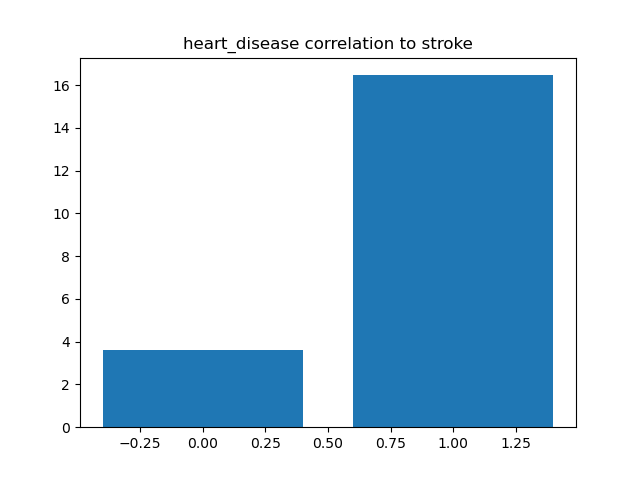

the percentage of strokes with 1 is 16.46090534979424%.
the percentage of strokes with 0 is 3.621945992284612%.
the percentage difference is 12.838959357509626%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


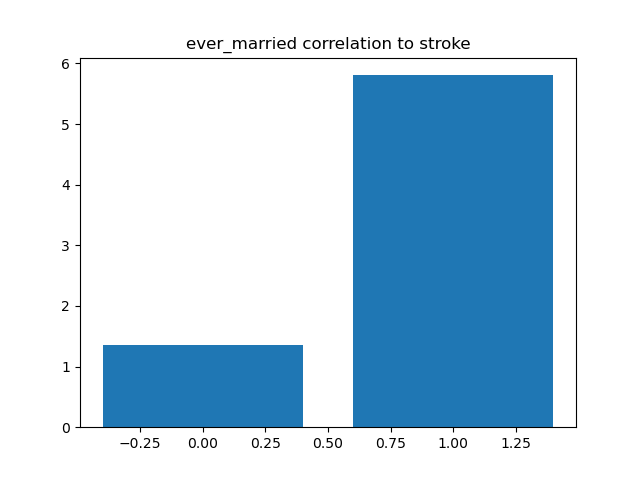

the percentage of strokes with 1 is 5.805243445692884%.
the percentage of strokes with 0 is 1.3489736070381233%.
the percentage difference is 4.456269838654761%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


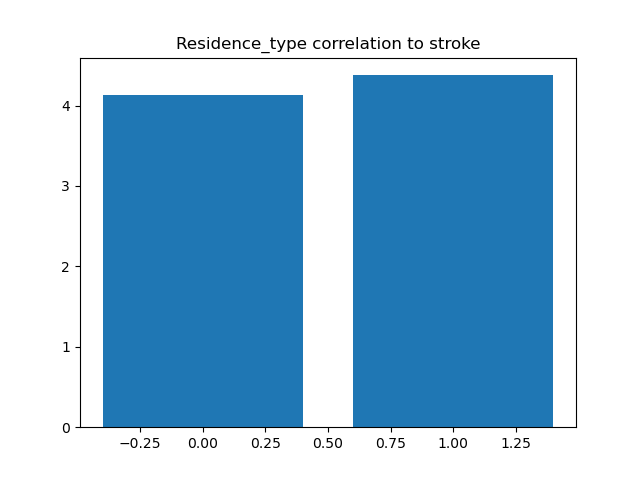

the percentage of strokes with 1 is 4.377510040160643%.
the percentage of strokes with 0 is 4.13393964448119%.
the percentage difference is 0.24357039567945282%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


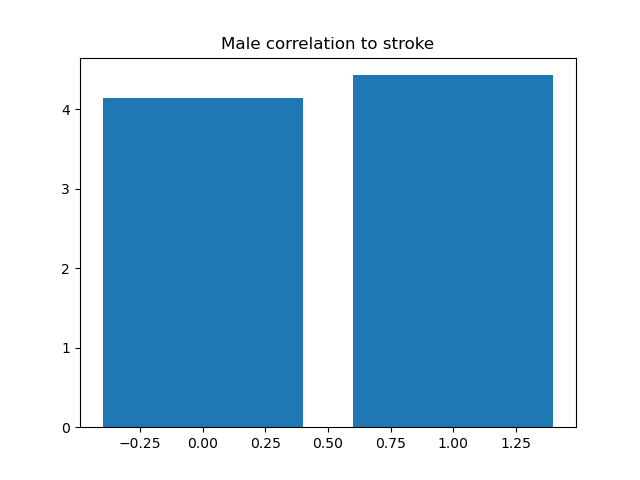

the percentage of strokes with 1 is 4.4256588761810045%.
the percentage of strokes with 0 is 4.140786749482402%.
the percentage difference is 0.28487212669860273%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


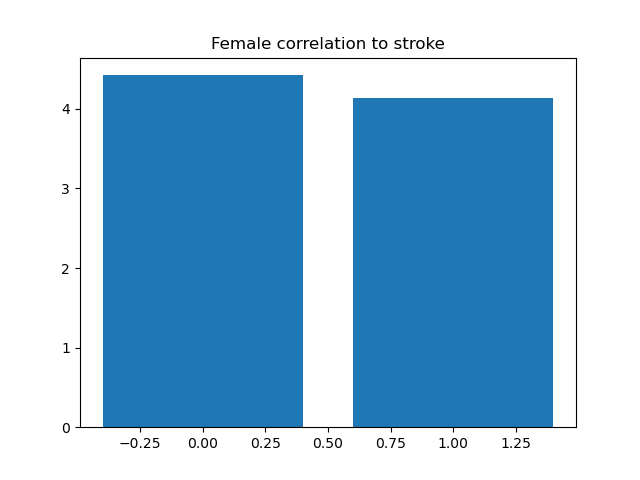

the percentage of strokes with 1 is 4.142216085605799%.
the percentage of strokes with 0 is 4.423459244532803%.
the percentage difference is -0.2812431589270039%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


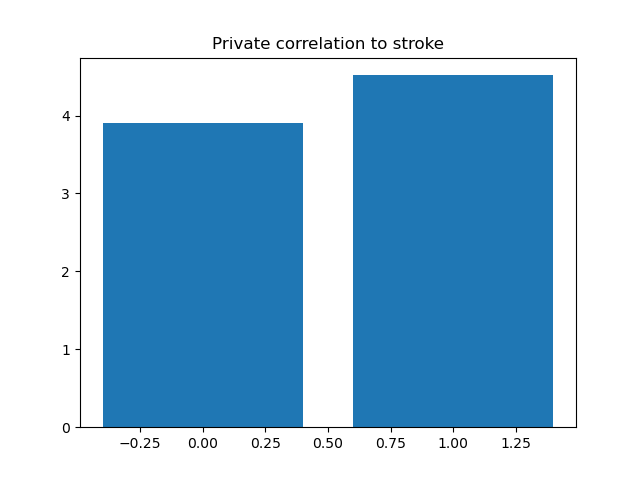

the percentage of strokes with 1 is 4.517965136961935%.
the percentage of strokes with 0 is 3.9084842707340326%.
the percentage difference is 0.6094808662279028%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


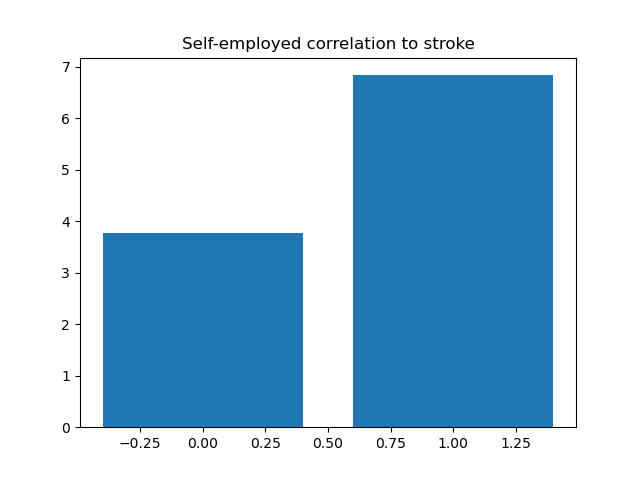

the percentage of strokes with 1 is 6.838709677419355%.
the percentage of strokes with 0 is 3.7735849056603774%.
the percentage difference is 3.0651247717589776%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


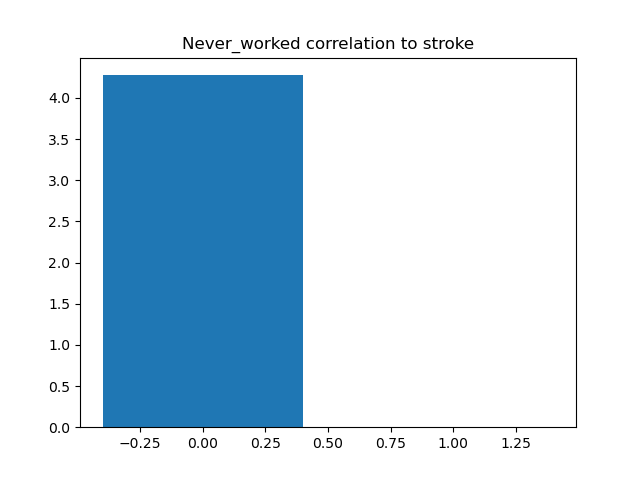

the percentage of strokes with 1 is 0.0%.
the percentage of strokes with 0 is 4.276652342950685%.
the percentage difference is -4.276652342950685%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


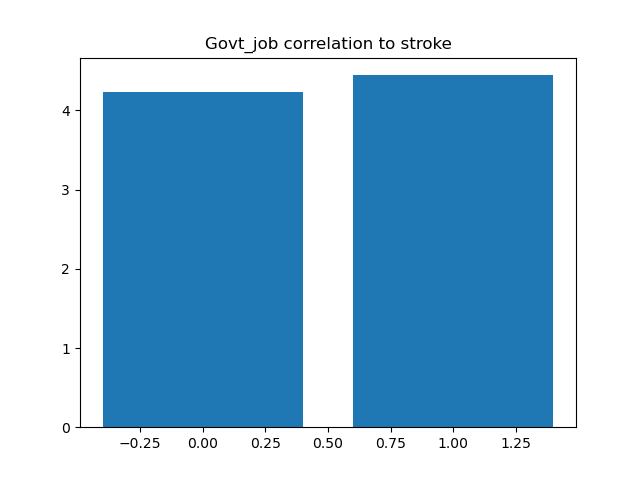

the percentage of strokes with 1 is 4.444444444444445%.
the percentage of strokes with 0 is 4.229960271091376%.
the percentage difference is 0.21448417335306846%.
---------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


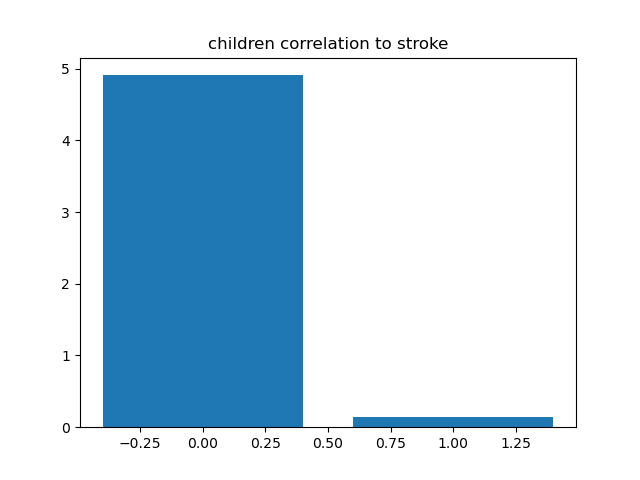

the percentage of strokes with 1 is 0.14903129657228018%.
the percentage of strokes with 0 is 4.9079754601226995%.
the percentage difference is -4.758944163550419%.
---------------------------------------------------------------------------------------------------------
['Never_worked', 'children', 'Self-employed', 'Residence_type', 'Male', 'Female', 'Private', 'Govt_job']


In [41]:
# run 2nd stage data preprocessing by correlation with stroke chance

# get all keys from datasheet
bols = []
for key in preprocessor.data.columns:
    bols.append(key)

# Columns in the dataset were either boolean (0 or 1) or scaled values
# This processor part only considers correlation between boolean values
# and strokes

# manually set non-bool keys acceptable for small column list
nbols = ['age','avg_glucose_level','bmi', 'smoking_status']

# so non-booleans are removed for this part:
for i in nbols:
    bols.remove(i)

bols.remove('stroke')

#FIXME: how are we handling smoking_status again?

# innitialse class
preplots = preplotter(preprocessor.data)

# create a list containing columns that will not have ML performed on them
badbols = ['Never_worked', 'children', 'Self-employed']
#badbols = []

# consider correlation betweeen having a positive (1) result for the columns
# that are left and whether that person had a stroke
for name in bols:
    #print(name)
    # return difference in percentage stroke, if there is correlation there would be a significant difference in stroke
    # amounts between the boolean anwsers
    dv = preplots.histogram(name)
    print('---------------------------------------------------------------------------------------------------------')
    # remove data that has similar stroke percentage i.e. non-predictive of stroke chances
    if abs(dv) < 1.1 : #ARBITRARY VALUE SET
        badbols.append(name)

print(badbols)

# remove 2nd wave of non-predictive data
for name in badbols:
    preprocessor.remove(name)
       
# save to new file
preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv', index=False)


We use the plotter class to check whether the non-boolean data is correlated.

age


<IPython.core.display.Javascript object>


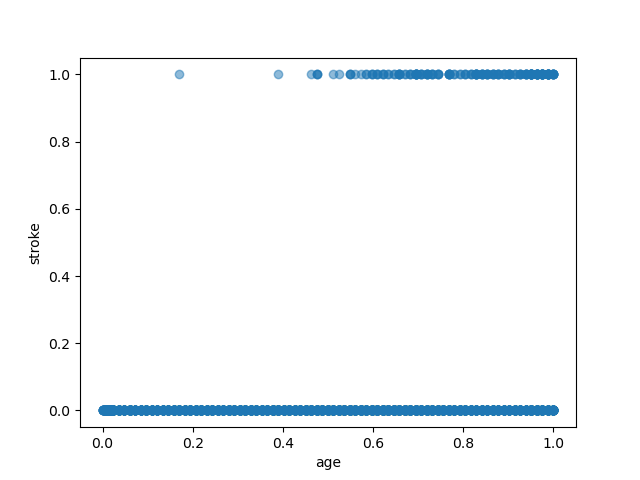

avg_glucose_level


<IPython.core.display.Javascript object>


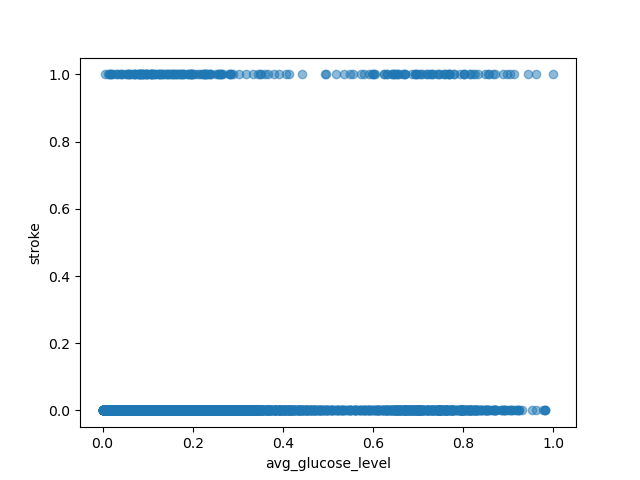

bmi


<IPython.core.display.Javascript object>


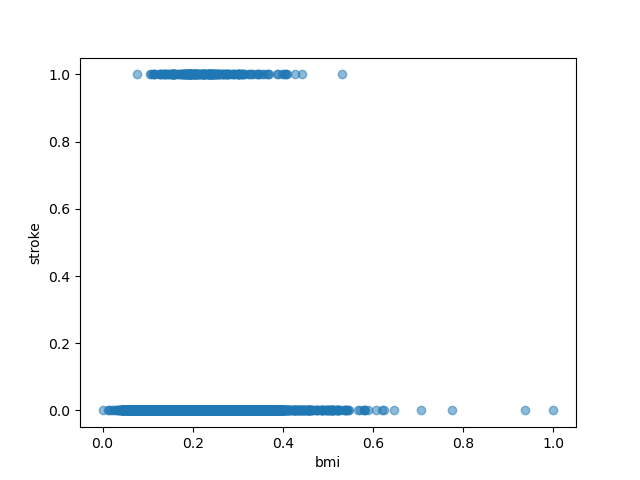

smoking_status


<IPython.core.display.Javascript object>


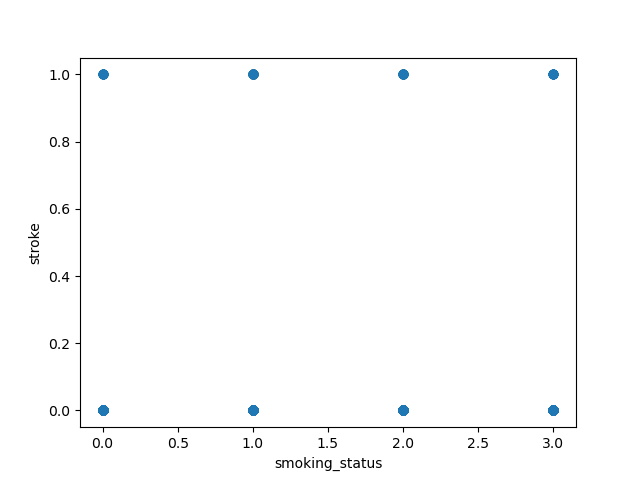

In [42]:
# print scatter graphs for each non-boolean function to check for corrolation
#FIXME: matplotlib titles
for name in nbols:
    print(name)
    preplots.scatter(name, 'stroke')

<IPython.core.display.Javascript object>


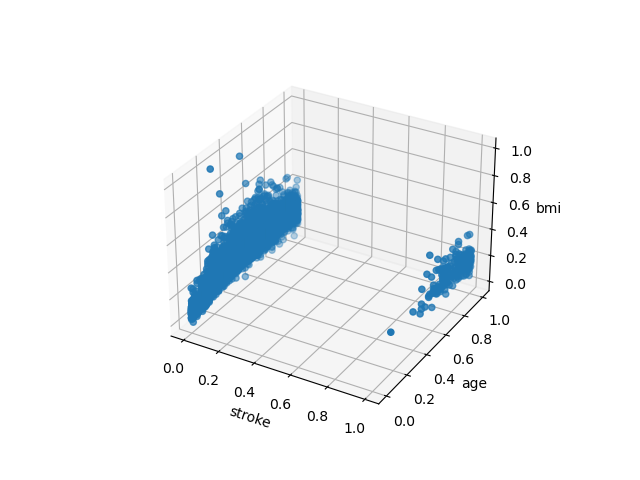

In [43]:
# Using a 3D scatter to show a clear correlation of age and bmi to stroke
# visualise data in 3D
#FIXME: plt.title()
preplots.scatter('stroke','age','bmi')

# Column removal

Here we removed columns from the preprocessed data, in preperation for the final notebook where the effects will be compared.

In [44]:
# Generate csvs for see effect of removing each column using radio buttons
# read preprocessed data to delete columns to used in the final cell, hence output to csv

# load preporcessed data
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# run loop over names
for name in data.columns:
    
    # generate class using copy of data so it can be reused in loop
    datap = Preprocessor(data.copy())
    # remove specific data column
    datare = datap.remove(name)
    # output to csv in diff file 
    datare.to_csv(f'data/data_removed/{name}_removed-healthcare-dataset-stroke-data.csv',)
# This is the final preprocessd data. CSVs have been generated with each column and the stroke column
data

age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0     0.816895             0              1             1           0.801265   
1     0.975586             0              1             1           0.234512   
2     0.597168             0              0             1           0.536008   
3     0.963379             1              0             1           0.549349   
4     0.987793             0              0             1           0.605161   
...        ...           ...            ...           ...                ...   
4904  0.157715             0              0             0           0.221402   
4905  0.987793             0              0             1           0.323516   
4906  0.426270             0              0             1           0.128658   
4907  0.621582             0              0             1           0.513203   
4908  0.536133             0              0             1           0.139230   

           bmi  smoking_status  stroke  
0     0.301260               2       1  
1     0.254296               1       1  
2     0.276060               0       1  
3     0.156930               1       1  
4     0.214204               2       1  
...        ...             ...     ...  
4904  0.095074               3       0  
4905  0.340206               1       0  
4906  0.232532               1       0  
4907  0.175258               2       0  
4908  0.182131               3       0  

[4909 rows x 8 columns]

# Implementing the classifier
In this section, we decide which of the classifiers to use and how to split our data 



## The regressor class
This class is initialised with any sci kit learn regressor/classifier object, any sci kit cross validation object and a csv file with the data. It fits the regressor with data split using the cross validator and stores the resulting y_pred, X_test and y_test values. 



In [45]:
def load(fname: str, cv: str) -> tuple:
    """Loads data from a CSV file and splits it using scikit"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
        # method that predicts new y values from new x data
    def predict(self, newdata):
        y = self.regressor.predict(newdata)
        return y

## The Postplotter class
This class creates the confusion matrix to compare cross-validation methods.

In [46]:
class postplotter:
    
    #initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self, title: str):
    
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        


        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='viridis')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for i in range(2):
            for j in range(2):

                # leave colour as white as the default
                color = 'black'
                if (i == 2 and j != 2):

                    # when overdose happened but wasn't predicted, changed colour
                    # to red if it is not 0
                    if array[i, j] == 0:
                        color = 'black'

                    else:
                        color = 'black'

                # set colour to black for the light coloured square
                # this is done after plotting once
                elif i == 1 and j == 1:
                    color = 'black'

                # add text with correct colour
                ax.text(j, i, array[i, j], ha='center', va='center', color=color)
        
        #sets axis title
        ax.set_title(title, fontsize=15)

        
        #calculates F1, P and R values
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            P = (array[1,1]/(array[1,1]+array[0,1]))*100
            F1 = 2*P*R/(P+R)
            confresults = pd.DataFrame({'Precision P': P, 'F-score F1': F1, 'Recall R': R }, index=[0])

        else:
            confresults = pd.DataFrame({'Precision P': 'N/A', 'F-score F1': 'N/A', 'Recall R': R }, index=[0])
            print("P and F1 could not be calculated due to 0 total correct guesses")

        print(confresults.to_string(index=False))



## Accuracy issue 
When using the regressor on the entire data sets, classifiers found the best fit to predict 100% of the data to not have a stroke. The way we resolved this issue is by making the regressor run on a sample of the data where we use all the data on strokes and an equal amount of data for non strokes. This is justified below as we checked how this method performed across all the non-stroke data in 22 intervals of 210.

Out of all the iterations, split 21 gave the best precision $P$

Iteration: 1


<IPython.core.display.Javascript object>


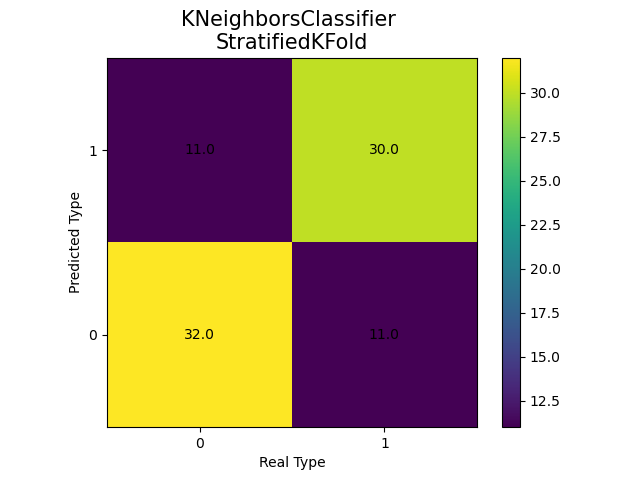

 Precision P  F-score F1  Recall R
   73.170732   73.170732 73.170732

Classifier R^2 Score: 0.7380952380952381

-----------------------------------------------------------

Iteration: 2


<IPython.core.display.Javascript object>


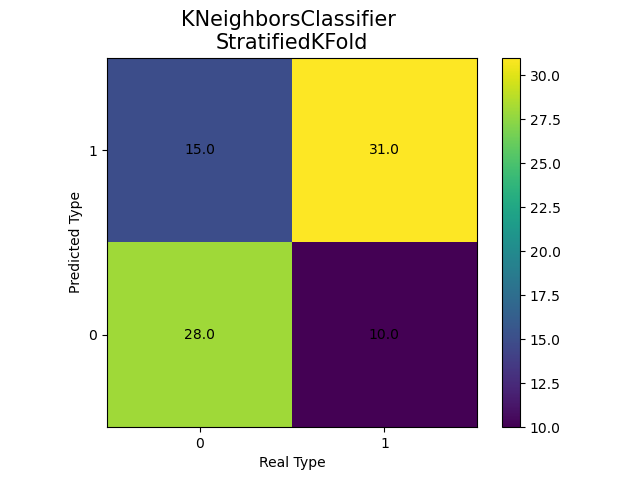

 Precision P  F-score F1  Recall R
   75.609756   71.264368 67.391304

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 3


<IPython.core.display.Javascript object>


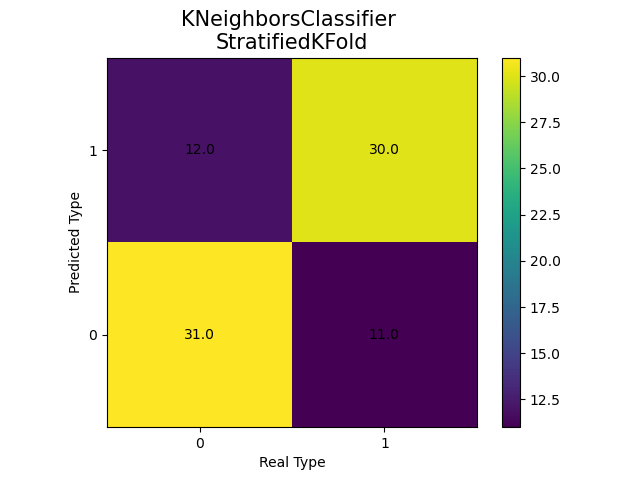

 Precision P  F-score F1  Recall R
   73.170732   72.289157 71.428571

Classifier R^2 Score: 0.7261904761904762

-----------------------------------------------------------

Iteration: 4


<IPython.core.display.Javascript object>


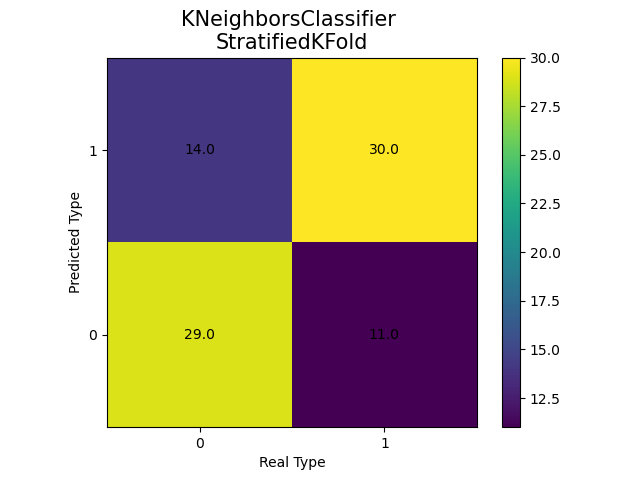

 Precision P  F-score F1  Recall R
   73.170732   70.588235 68.181818

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 5


<IPython.core.display.Javascript object>


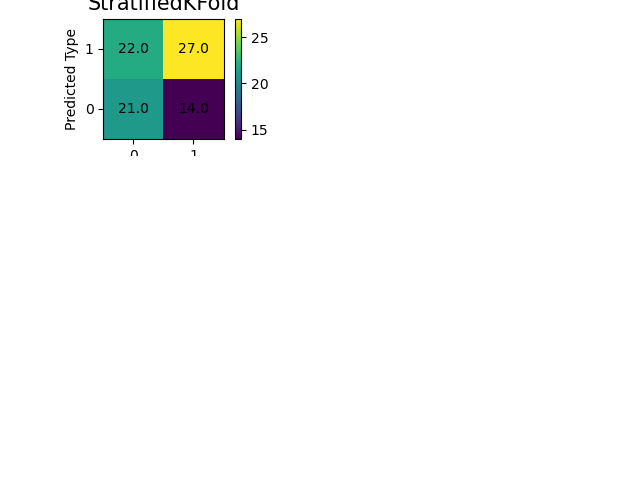

 Precision P  F-score F1  Recall R
   65.853659        60.0 55.102041

Classifier R^2 Score: 0.5714285714285714

-----------------------------------------------------------

Iteration: 6


<IPython.core.display.Javascript object>


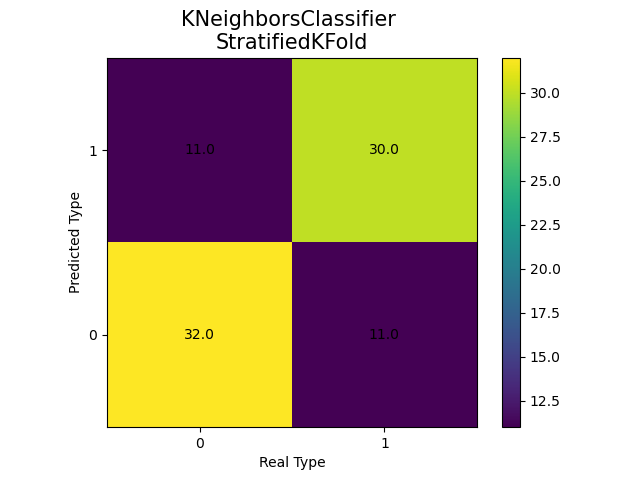

 Precision P  F-score F1  Recall R
   73.170732   73.170732 73.170732

Classifier R^2 Score: 0.7380952380952381

-----------------------------------------------------------

Iteration: 7


<IPython.core.display.Javascript object>


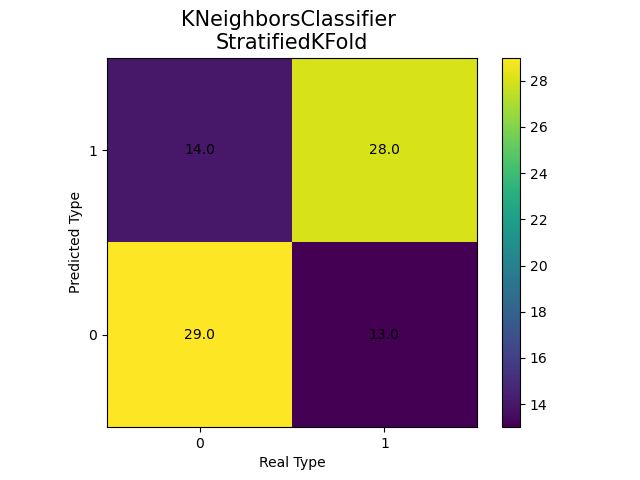

 Precision P  F-score F1  Recall R
   68.292683    67.46988 66.666667

Classifier R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 8


<IPython.core.display.Javascript object>


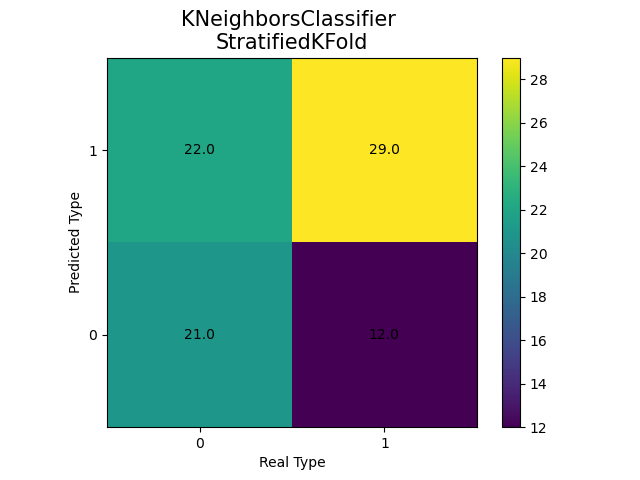

 Precision P  F-score F1  Recall R
   70.731707   63.043478 56.862745

Classifier R^2 Score: 0.5952380952380952

-----------------------------------------------------------

Iteration: 9


<IPython.core.display.Javascript object>


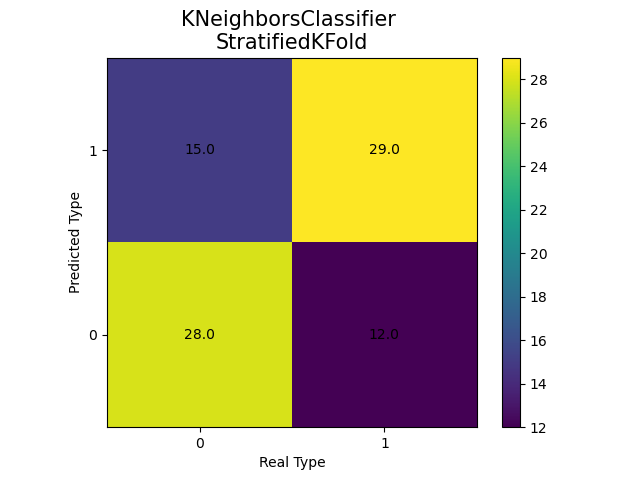

 Precision P  F-score F1  Recall R
   70.731707   68.235294 65.909091

Classifier R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 10


<IPython.core.display.Javascript object>


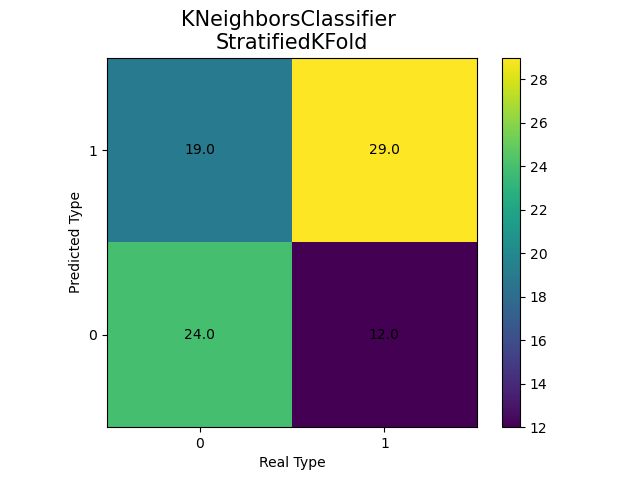

 Precision P  F-score F1  Recall R
   70.731707   65.168539 60.416667

Classifier R^2 Score: 0.6309523809523809

-----------------------------------------------------------

Iteration: 11


<IPython.core.display.Javascript object>


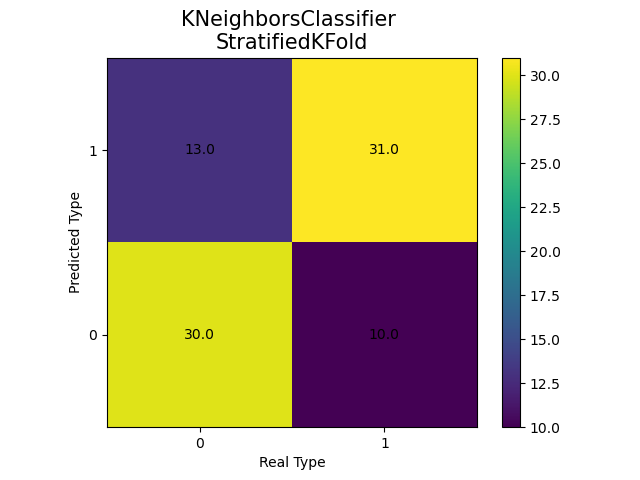

 Precision P  F-score F1  Recall R
   75.609756   72.941176 70.454545

Classifier R^2 Score: 0.7261904761904762

-----------------------------------------------------------

Iteration: 12


<IPython.core.display.Javascript object>


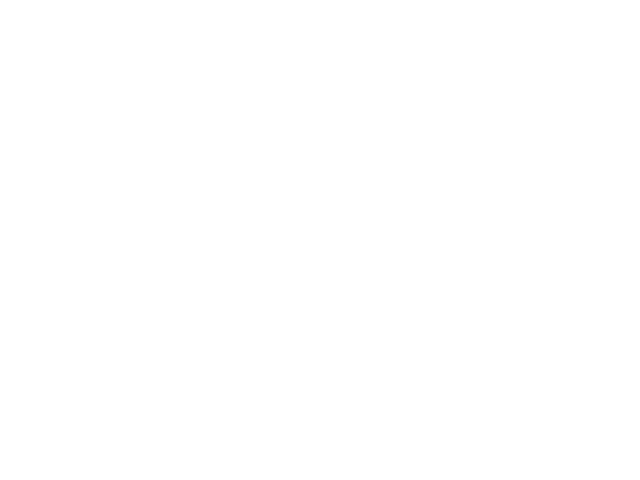

 Precision P  F-score F1  Recall R
   70.731707   69.879518 69.047619

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 13


<IPython.core.display.Javascript object>


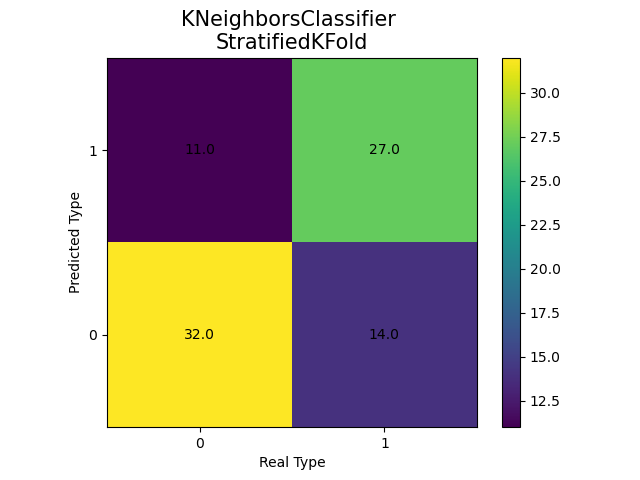

 Precision P  F-score F1  Recall R
   65.853659    68.35443 71.052632

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 14


<IPython.core.display.Javascript object>


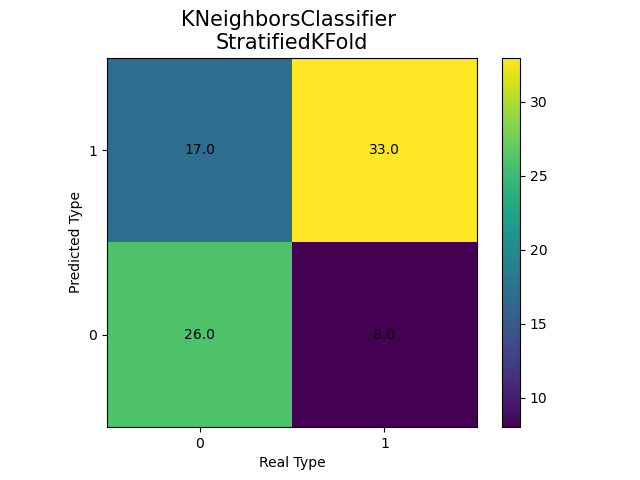

 Precision P  F-score F1  Recall R
   80.487805   72.527473      66.0

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 15


<IPython.core.display.Javascript object>


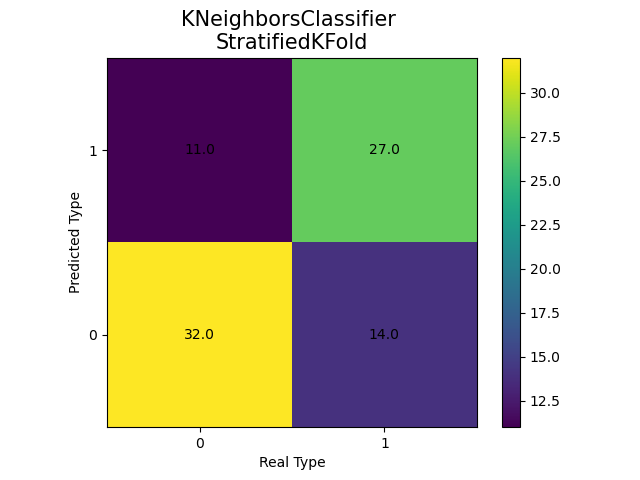

 Precision P  F-score F1  Recall R
   65.853659    68.35443 71.052632

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 16


<IPython.core.display.Javascript object>


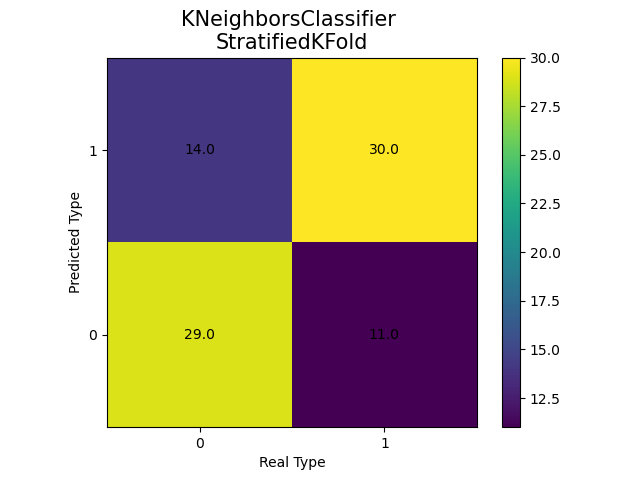

 Precision P  F-score F1  Recall R
   73.170732   70.588235 68.181818

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 17


<IPython.core.display.Javascript object>


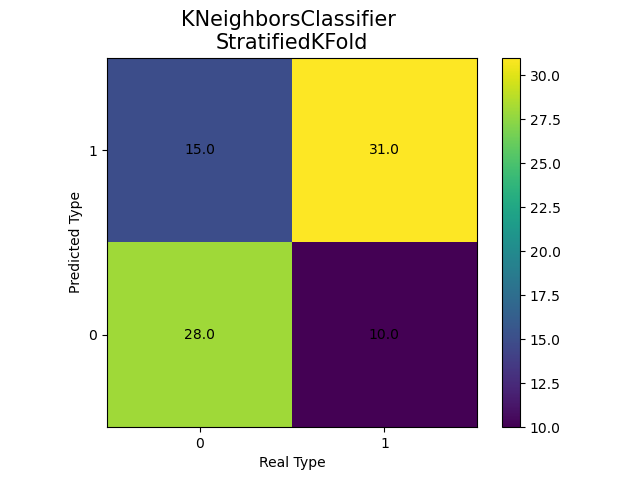

 Precision P  F-score F1  Recall R
   75.609756   71.264368 67.391304

Classifier R^2 Score: 0.7023809523809523

-----------------------------------------------------------

Iteration: 18


<IPython.core.display.Javascript object>


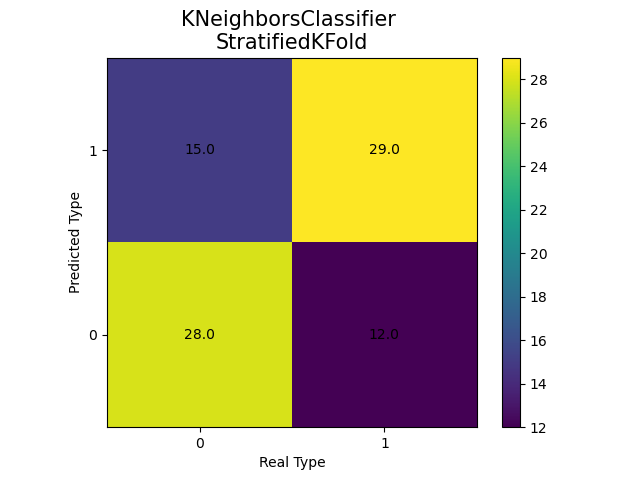

 Precision P  F-score F1  Recall R
   70.731707   68.235294 65.909091

Classifier R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 19


<IPython.core.display.Javascript object>


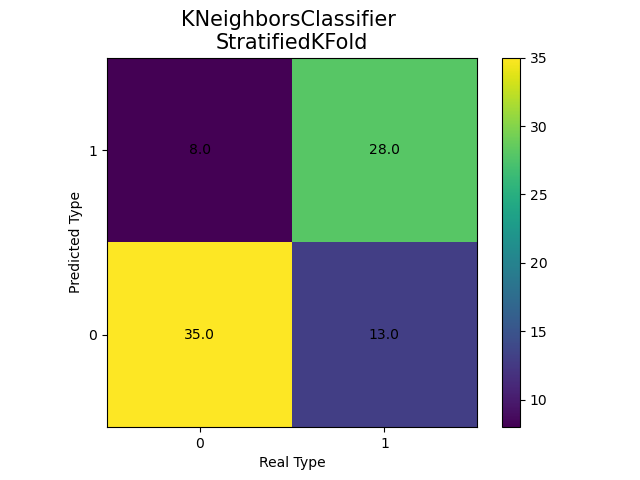

 Precision P  F-score F1  Recall R
   68.292683   72.727273 77.777778

Classifier R^2 Score: 0.75

-----------------------------------------------------------

Iteration: 20


<IPython.core.display.Javascript object>


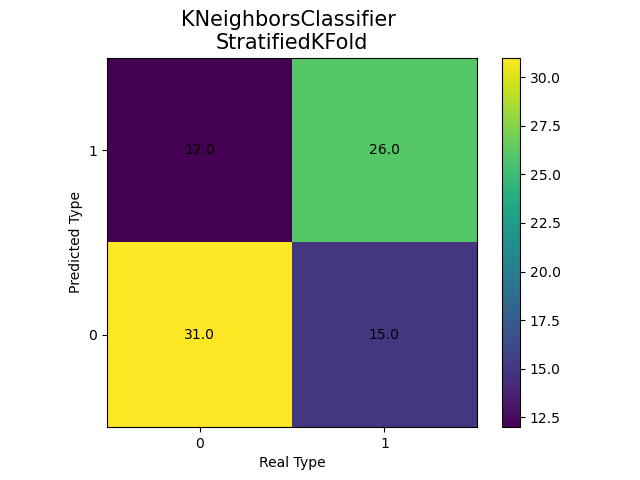

 Precision P  F-score F1  Recall R
   63.414634   65.822785 68.421053

Classifier R^2 Score: 0.6785714285714286

-----------------------------------------------------------

Iteration: 21


<IPython.core.display.Javascript object>


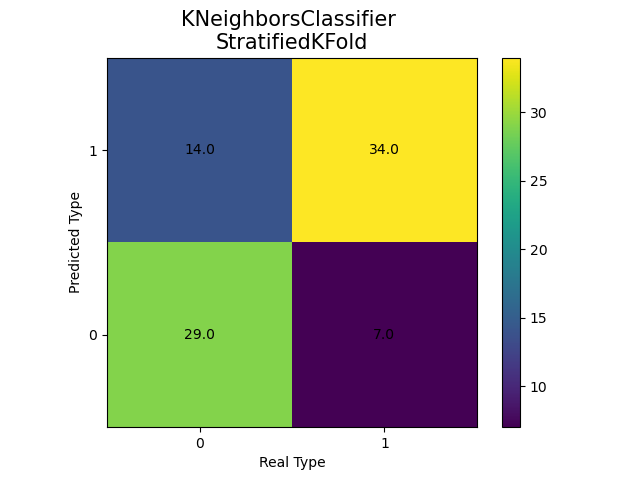

 Precision P  F-score F1  Recall R
   82.926829   76.404494 70.833333

Classifier R^2 Score: 0.75

-----------------------------------------------------------



In [47]:
#trying the KNeighbours classifier to justify using small amounts of the data to train the classifier 
daata = pd.read_csv('data/preprocessed2-healthcare-dataset-stroke-data.csv')
strdata = daata.iloc[:210, :] #210 rows of stroke data
for n in range(1,22): #22 lots of 210 in non-stroke data
    rnddata = daata.iloc[210+n*210:210+(n+1)*210,:]
    concat = strdata.append(rnddata)  
    concat.to_csv(f'data/splits/split{n}.csv', index = False)
    rg = Regressor(KNeighborsClassifier, f'data/splits/split{n}.csv', StratifiedKFold)
    a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
    print(f'Iteration: {n}')
    a.confmatrix('{}'.format(type(rg.regressor).__name__)+' \n{}'.format(type(rg.cv).__name__ ) )
    print(f'\nClassifier R^2 Score: {rg.regressor.score(rg.X_test, rg.y_test)}\n\n-----------------------------------------------------------\n')

## Selecting a classifier and splitting method
In this cell we looped our regressor class over different CV and regression objects from scikit learn and compared the best F-scores to determine which we would use for our data. 

In [48]:
#borrowed from the scikit learn documentation to visualise the different splitting techniques
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

<IPython.core.display.Javascript object>


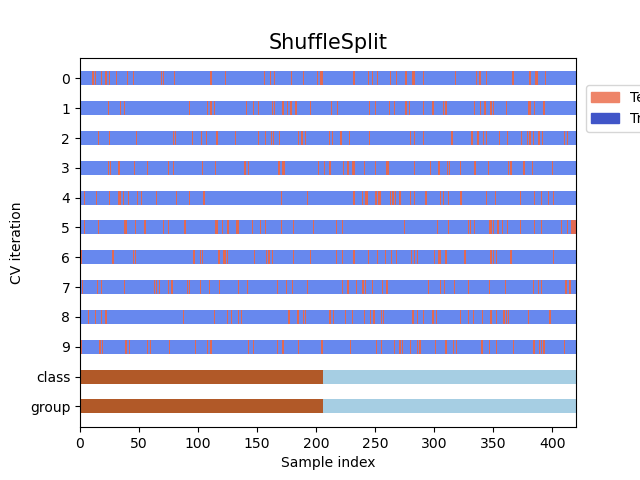

<IPython.core.display.Javascript object>


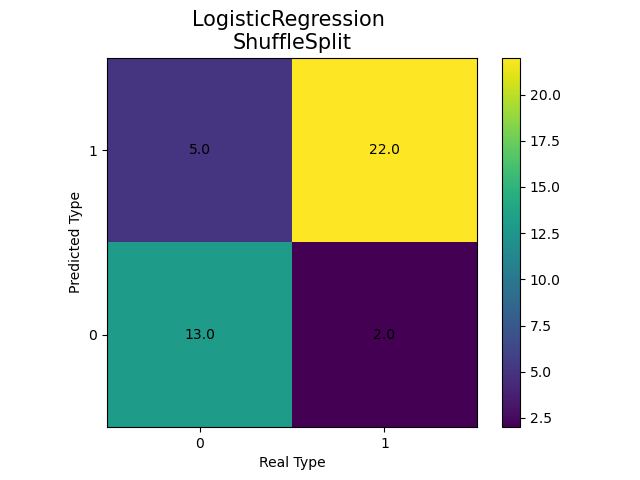

 Precision P  F-score F1  Recall R
   91.666667    86.27451 81.481481

Classifier R^2 Score: 0.8333333333333334

-----------------------------------------------------------



<IPython.core.display.Javascript object>


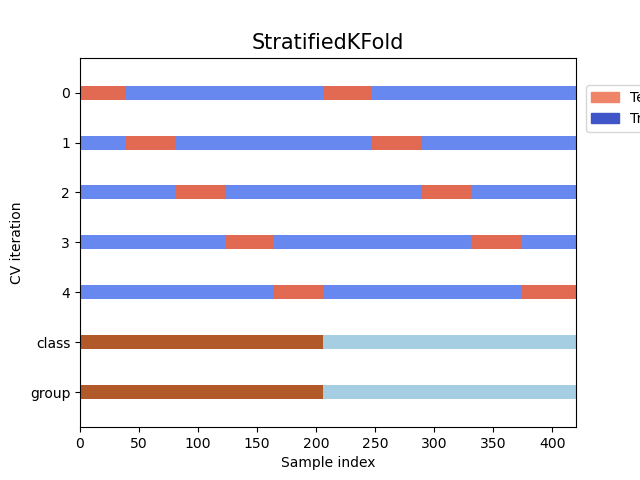

<IPython.core.display.Javascript object>


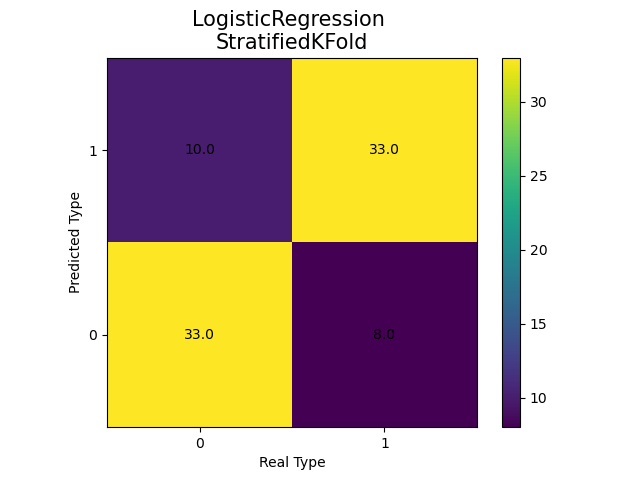

 Precision P  F-score F1  Recall R
   80.487805   78.571429 76.744186

Classifier R^2 Score: 0.7857142857142857

-----------------------------------------------------------



<IPython.core.display.Javascript object>


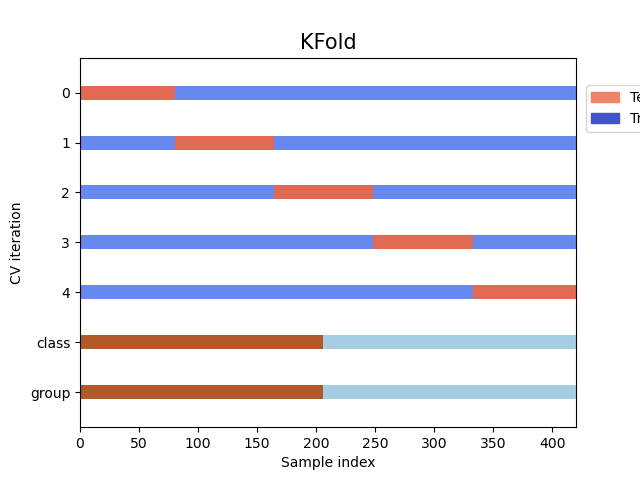

<IPython.core.display.Javascript object>


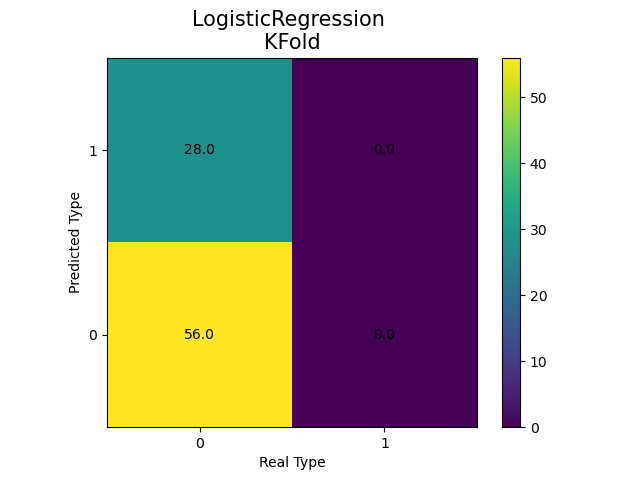

P and F1 could not be calculated due to 0 total correct guesses
Precision P F-score F1  Recall R
        N/A        N/A       0.0

Classifier R^2 Score: 0.6666666666666666

-----------------------------------------------------------



<IPython.core.display.Javascript object>


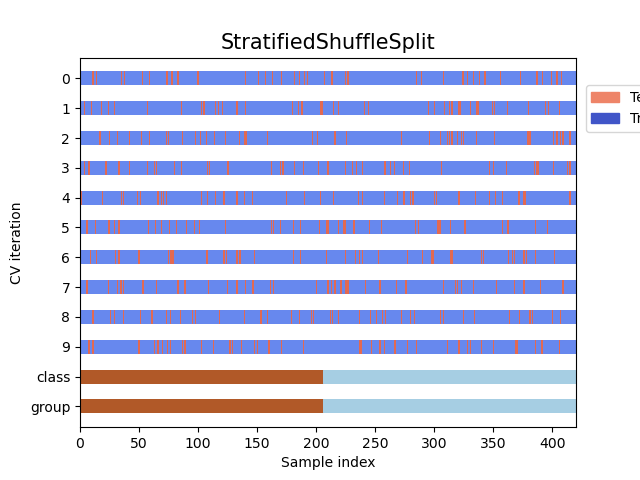

<IPython.core.display.Javascript object>


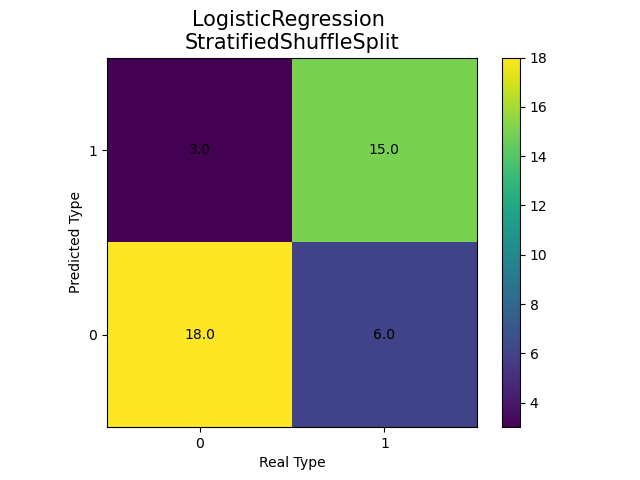

 Precision P  F-score F1  Recall R
   71.428571   76.923077 83.333333

Classifier R^2 Score: 0.7857142857142857

-----------------------------------------------------------



<IPython.core.display.Javascript object>


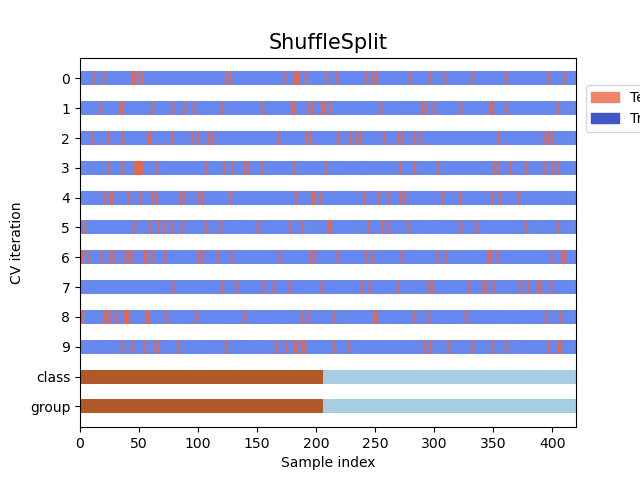

<IPython.core.display.Javascript object>


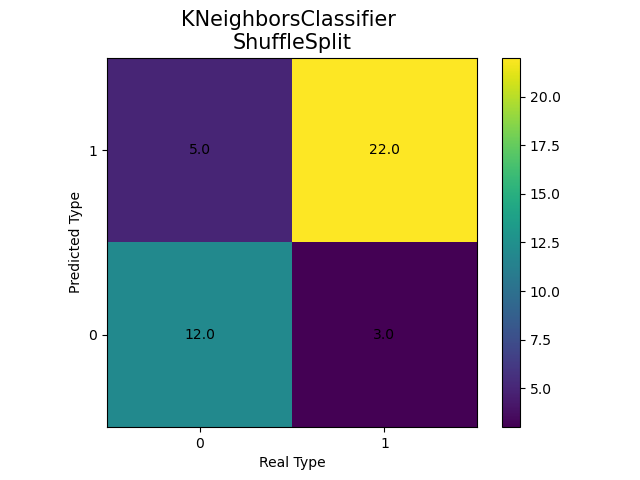

 Precision P  F-score F1  Recall R
        88.0   84.615385 81.481481

Classifier R^2 Score: 0.8095238095238095

-----------------------------------------------------------



<IPython.core.display.Javascript object>


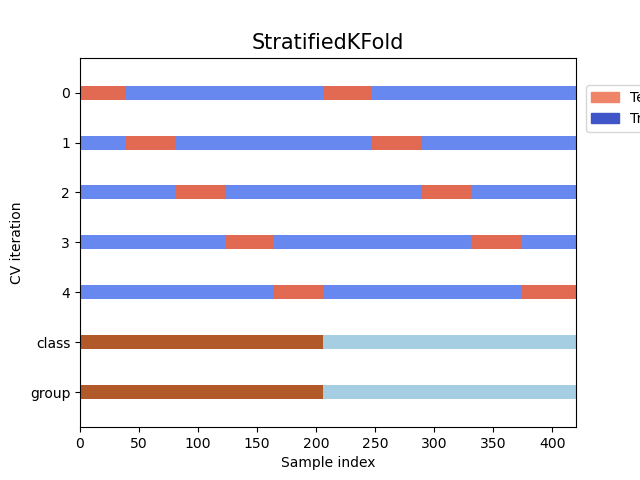

<IPython.core.display.Javascript object>


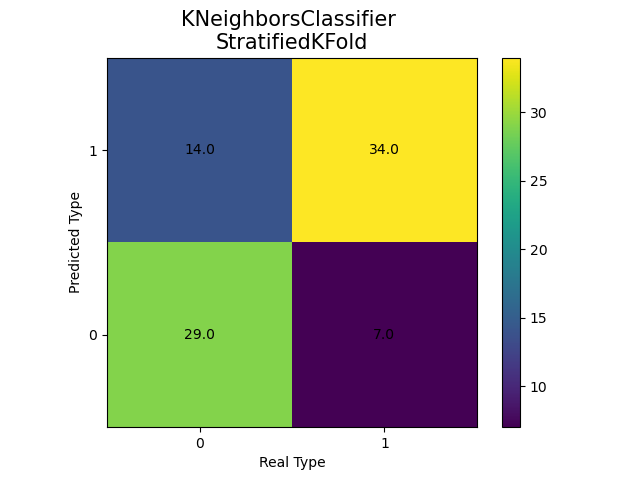

 Precision P  F-score F1  Recall R
   82.926829   76.404494 70.833333

Classifier R^2 Score: 0.75

-----------------------------------------------------------



<IPython.core.display.Javascript object>


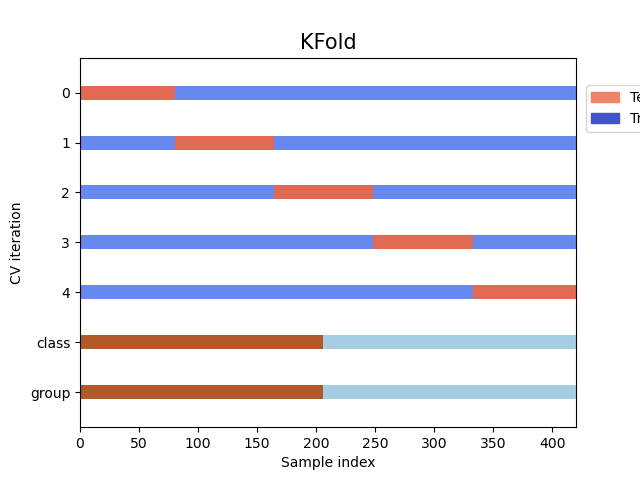

<IPython.core.display.Javascript object>


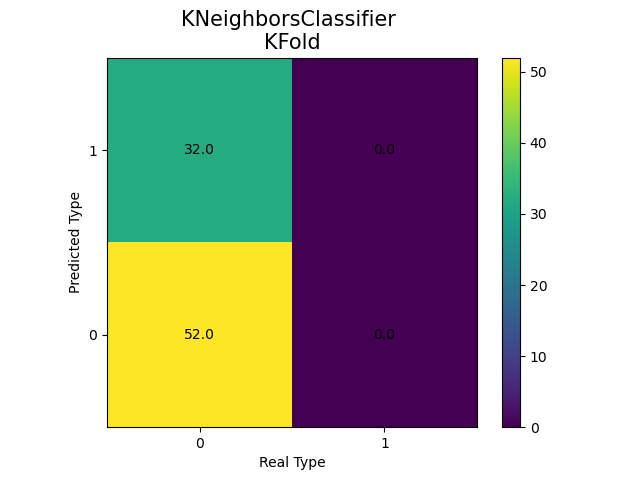

P and F1 could not be calculated due to 0 total correct guesses
Precision P F-score F1  Recall R
        N/A        N/A       0.0

Classifier R^2 Score: 0.6190476190476191

-----------------------------------------------------------



<IPython.core.display.Javascript object>


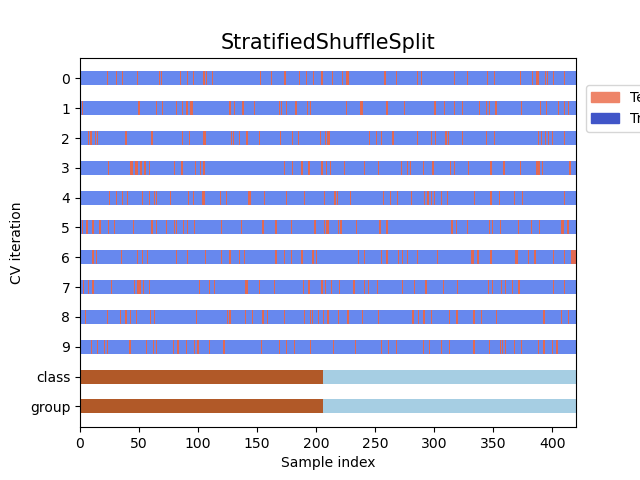

<IPython.core.display.Javascript object>


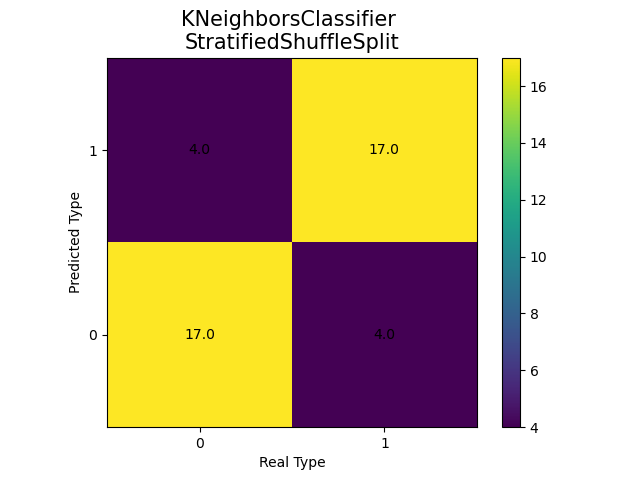

 Precision P  F-score F1  Recall R
   80.952381   80.952381 80.952381

Classifier R^2 Score: 0.8095238095238095

-----------------------------------------------------------



<IPython.core.display.Javascript object>


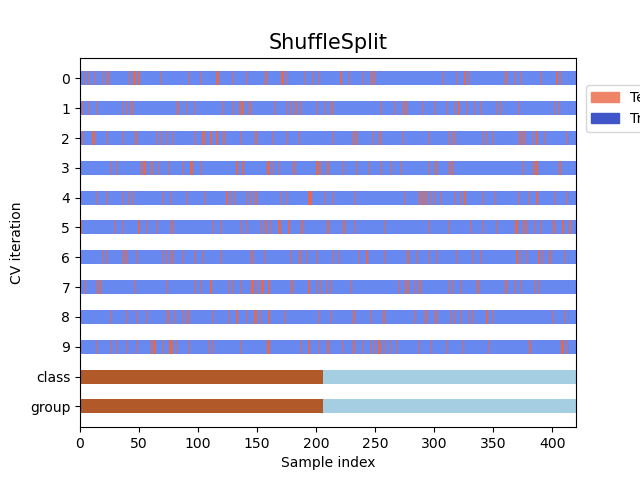

<IPython.core.display.Javascript object>


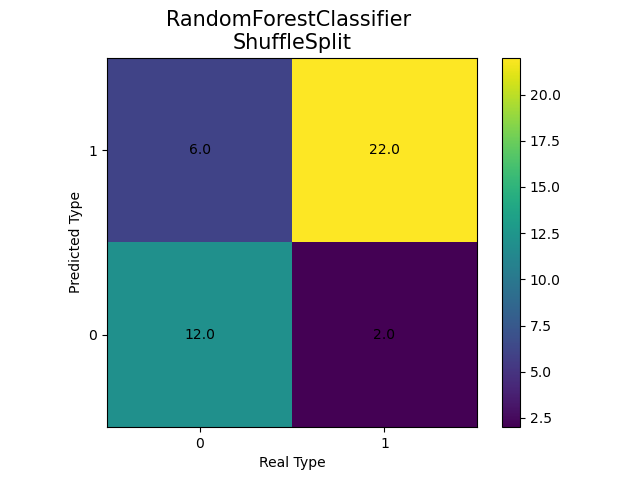

 Precision P  F-score F1  Recall R
   91.666667   84.615385 78.571429

Classifier R^2 Score: 0.8095238095238095

-----------------------------------------------------------



<IPython.core.display.Javascript object>


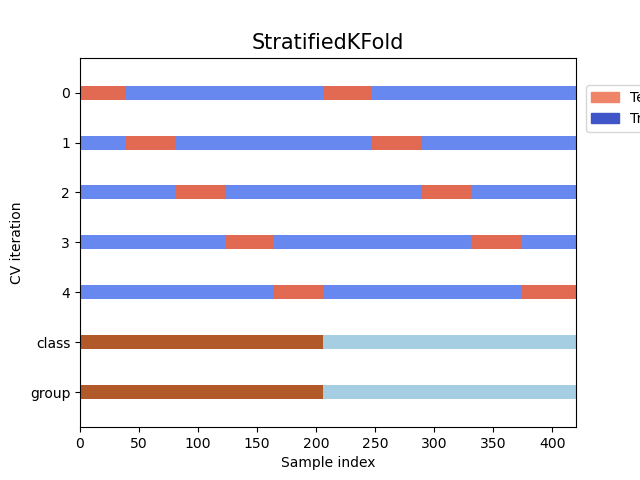

<IPython.core.display.Javascript object>


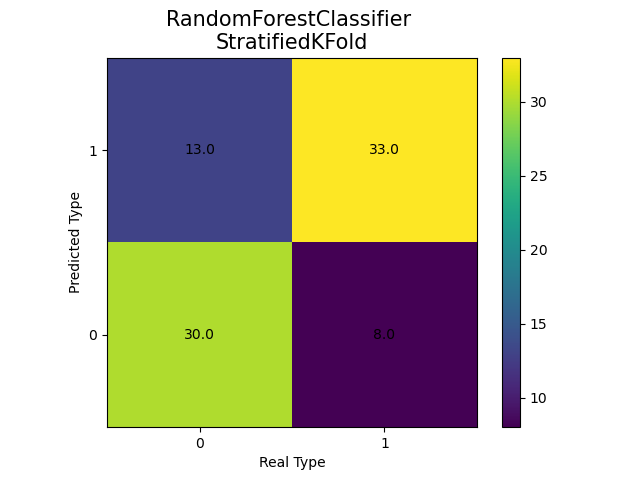

 Precision P  F-score F1  Recall R
   80.487805   75.862069  71.73913

Classifier R^2 Score: 0.75

-----------------------------------------------------------



<IPython.core.display.Javascript object>


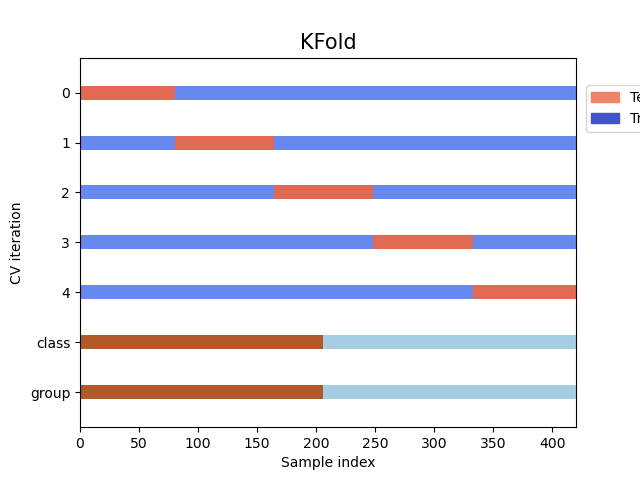

<IPython.core.display.Javascript object>


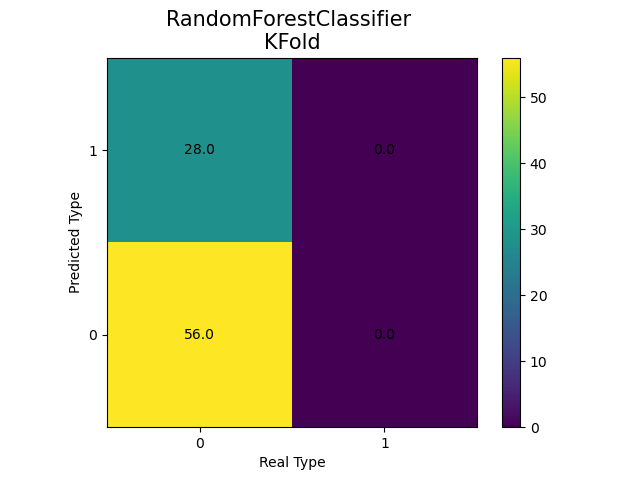

P and F1 could not be calculated due to 0 total correct guesses
Precision P F-score F1  Recall R
        N/A        N/A       0.0

Classifier R^2 Score: 0.6666666666666666

-----------------------------------------------------------



<IPython.core.display.Javascript object>


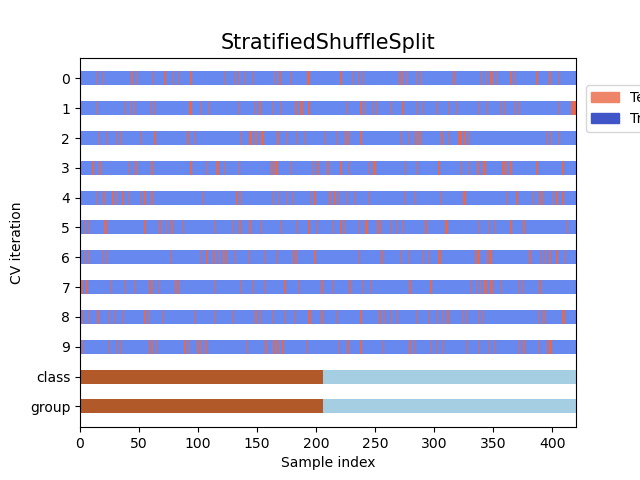

<IPython.core.display.Javascript object>


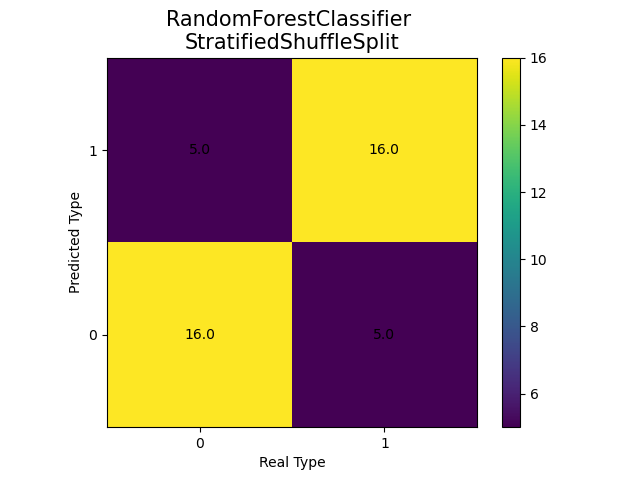

 Precision P  F-score F1  Recall R
   76.190476   76.190476 76.190476

Classifier R^2 Score: 0.7619047619047619

-----------------------------------------------------------



In [49]:
#Running different regressors with different splitting techniques and returns the confusion matrix in order
#to determine which ones to use for the data 
reg_list = [LogisticRegression, KNeighborsClassifier, RandomForestClassifier]
cv_list = [ShuffleSplit, StratifiedKFold, KFold, StratifiedShuffleSplit]
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
#DEFINE FNAME #MASTER LOOP
fname = 'data/splits/split21.csv'
groups_ = data['stroke'].to_numpy()
for regressor in reg_list: 
    for cv in cv_list:
        rg = Regressor(regressor, fname, cv)
        a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
        fig, ax = plt.subplots()
        plot_cv_indices(rg.cv, rg.X, rg.y, rg.y, ax, rg.cv.get_n_splits() )
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))

        #alternatively: use regressor as string from reg_list
        a.confmatrix( '{}'.format(type(rg.regressor).__name__)+' \n{}'.format(type(cv()).__name__)  )
        print(f'\nClassifier R^2 Score: {rg.regressor.score(rg.X_test, rg.y_test)}\n\n-----------------------------------------------------------\n')

In the end we decided it is best to use stratified Kfold so an even amount of the stroke data and non stroke data is used to fit the model. 

We chose to proceed with the K Nearest Neighbours classifier as it gave the highest $P$ and $R^2$.

Once we decided to use these, the predicitivity was further analysed in Notebook 2.